## Data Processing


###  Data Processing Workflow

This notebook prepares the input tensor for the U-Net model by combining satellite data and OSM masks.

#### Load Raster Data
- Import Sentinel-2 bands
- Import Landsat 8 LST band
- Import rasterized OSM Masks

In [ ]:
import rasterio
import os
import numpy as np

project_root = os.path.dirname(os.getcwd())
raw_dir = os.path.join(project_root, 'data', 'raw')

# Define sub-directories based on previous tasks
sentinel_dir = os.path.join(raw_dir, 'sentinel_2')
#Change to landsat_lst for the new data structure
lst_dir = os.path.join(raw_dir, 'landsat_lst')
osm_dir = os.path.join(raw_dir, 'osm')

print(f"Data directory set to: {raw_dir}")

# Define the range of years processed (2014-2024)
years = list(range(2014, 2025))

Data directory set to: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/raw_v2


In [5]:
# 3. Load Dynamic Data (Sentinel-2 and LST)
print("\n--- Loading Satellite Imagery (Dynamic) ---")

# Dictionaries to store loaded rasters
sentinel_data = {}
lst_data = {}

for year in years:
    # Define file paths
    s2_path = os.path.join(sentinel_dir, f'Hamburg_Composite_{year}.tif')
    lst_path = os.path.join(lst_dir, f'LST_{year}_Hamburg.tif')

    try:
        # Load Sentinel-2
        if os.path.exists(s2_path):
            with rasterio.open(s2_path) as src:
                sentinel_data[year] = {
                    'data': src.read(),  # Reads all bands (Bands, Height, Width)
                    'meta': src.meta
                }
        else:
            print(f"Warning: Sentinel file missing for {year}")

        # Load LST
        if os.path.exists(lst_path):
            with rasterio.open(lst_path) as src:
                lst_data[year] = {
                    'data': src.read(1), # Read first band only (LST is single band)
                    'meta': src.meta
                }
        else:
            print(f"Warning: LST file missing for {year}")

        # Print loaded shapes for verification
        if year in sentinel_data and year in lst_data:
            print(f"Loaded {year}: Sentinel shape {sentinel_data[year]['data'].shape}, LST shape {lst_data[year]['data'].shape}")

    except Exception as e:
        print(f"Error loading data for {year}: {e}")


--- Loading Satellite Imagery (Dynamic) ---
Loaded 2014: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2015: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2016: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2017: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2018: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2019: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2020: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2021: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2022: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2023: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)
Loaded 2024: Sentinel shape (3, 3344, 6681), LST shape (1116, 2227)


In [6]:
# 4. Load Static Data (OSM Masks)
print("\n--- Loading OSM Masks (Static) ---")

osm_data = {}
# List of expected filenames (ensure these match your previous export)
osm_layers = ['static_building', 'static_highway', 'static_water', 'static_natural']

for layer in osm_layers:
    file_path = os.path.join(osm_dir, f'{layer}.tif')
    
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            osm_data[layer] = {
                'data': src.read(1), # Masks are single band
                'meta': src.meta
            }
        print(f"Loaded Mask: {layer} with shape {osm_data[layer]['data'].shape}")
    else:
        print(f"Warning: OSM mask missing: {layer}")

print("\nStep 1 Complete: All available raster data loaded into memory.")


--- Loading OSM Masks (Static) ---
Loaded Mask: static_building with shape (3344, 6681)
Loaded Mask: static_highway with shape (3344, 6681)
Loaded Mask: static_natural with shape (3344, 6681)

Step 1 Complete: All available raster data loaded into memory.


#### Align and Reproject
- Ensure all rasters have the same CRS and resolution (e.g., 10m)

In [7]:
import cv2
import numpy as np

# 1. Define Target Shape (Based on OSM/Sentinel High-Res)
# We take the shape from the 2024 Sentinel image which we know is correct (10m resolution)
TARGET_HEIGHT = 3344
TARGET_WIDTH = 6681

print(f"Target Shape for all tensors: ({TARGET_HEIGHT}, {TARGET_WIDTH})")

# 2. Resize Function
def resize_image(image_array, target_h, target_w):
    """
    Resizes an image array to the target dimensions using cubic interpolation.
    Handles both 2D (single band) and 3D (multi-band) arrays.
    """
    # Check if image is 3D (Bands, Height, Width) or 2D (Height, Width)
    if len(image_array.shape) == 3:
        # Transpose to (Height, Width, Bands) for cv2.resize
        img_transposed = image_array.transpose(1, 2, 0)
        # Resize
        img_resized = cv2.resize(img_transposed, (target_w, target_h), interpolation=cv2.INTER_CUBIC)
        # Transpose back to (Bands, Height, Width)
        return img_resized.transpose(2, 0, 1)
    else:
        # Direct resize for 2D array
        return cv2.resize(image_array, (target_w, target_h), interpolation=cv2.INTER_CUBIC)

# 3. Process and Align Data
aligned_data = {}

print("\n--- Starting Alignment Process ---")

for year in years:
    print(f"Processing Year: {year}...")
    
    # --- A. Align Sentinel Data ---
    if year in sentinel_data:
        raw_s2 = sentinel_data[year]['data']
        
        # If shapes match, keep as is. If not, resize.
        if raw_s2.shape[1:] == (TARGET_HEIGHT, TARGET_WIDTH):
            s2_final = raw_s2
        else:
            print(f"   -> Upscaling Sentinel ({year}) from {raw_s2.shape} to target...")
            s2_final = resize_image(raw_s2, TARGET_HEIGHT, TARGET_WIDTH)
    else:
        print(f"   -> Warning: Missing Sentinel data for {year}")
        continue # Skip if main data is missing

    # --- B. Align LST Data ---
    if year in lst_data:
        raw_lst = lst_data[year]['data']
        
        if raw_lst.shape == (TARGET_HEIGHT, TARGET_WIDTH):
            lst_final = raw_lst
        else:
            # LST is almost always lower res, so this will run often
            # print(f"   -> Upscaling LST ({year}) from {raw_lst.shape} to target...")
            lst_final = resize_image(raw_lst, TARGET_HEIGHT, TARGET_WIDTH)
    else:
        print(f"   -> Warning: Missing LST data for {year}")
        # Create a dummy empty array if missing (to avoid breaking the pipeline), or skip
        lst_final = np.zeros((TARGET_HEIGHT, TARGET_WIDTH))

    # --- Store Aligned Data ---
    aligned_data[year] = {
        'sentinel': s2_final,
        'lst': lst_final
    }

print("\n All data aligned to (3344, 6681).")

Target Shape for all tensors: (3344, 6681)

--- Starting Alignment Process ---
Processing Year: 2014...
Processing Year: 2015...
Processing Year: 2016...
Processing Year: 2017...
Processing Year: 2018...
Processing Year: 2019...
Processing Year: 2020...
Processing Year: 2021...
Processing Year: 2022...
Processing Year: 2023...
Processing Year: 2024...

 All data aligned to (3344, 6681).


#### Compute Spectral Indices (NDVI & NDBI)

In this step, we derive key environmental indicators from the aligned satellite imagery to serve as dynamic input features for the U-Net model. Using the multi-band data (Sentinel-2 and Landsat), we calculate two critical indices that strongly correlate with surface temperature.

**1. Normalized Difference Vegetation Index (NDVI)**
* **Purpose:** Quantifies the density and health of vegetation. Vegetation provides a cooling effect through evapotranspiration.
* **Formula:**
    $$NDVI = \frac{(NIR - Red)}{(NIR + Red)}$$

**2. Normalized Difference Built-up Index (NDBI)**
* **Purpose:** Highlights urban built-up areas (asphalt, concrete, roof tiles). These impervious surfaces absorb heat and are the primary drivers of the Urban Heat Island effect.
* **Formula:**
    $$NDBI = \frac{(SWIR - NIR)}{(SWIR + NIR)}$$

**Band Mapping:**
Based on our data acquisition pipeline, the bands are indexed as follows:
* **Band 0:** Red
* **Band 3:** NIR (Near-Infrared)
* **Band 4:** SWIR (Short-Wave Infrared)

In [8]:
# Index 0: Red
# Index 1: NIR
# Index 2: SWIR

calculated_indices = {}

print("\n--- Computing Spectral Indices ---")

for year, data in aligned_data.items():
    # Get the aligned multi-band satellite image (Bands, Height, Width)
    img = data['sentinel'].astype(float) # Convert to float
    
    # Extract relevant bands
    red = img[0]
    nir = img[1]  
    swir = img[2] 
    
    # Allow division by zero (will produce NaNs, handled later)
    np.seterr(divide='ignore', invalid='ignore')
    
    # --- Calculate NDVI ---
    # Formula: (NIR - Red) / (NIR + Red)
    ndvi = (nir - red) / (nir + red + 1e-6) # Add epsilon
    
    # --- Calculate NDBI ---
    # Formula: (SWIR - NIR) / (SWIR + NIR)
    ndbi = (swir - nir) / (swir + nir + 1e-6)
    
    # Store results
    calculated_indices[year] = {
        'ndvi': ndvi,
        'ndbi': ndbi
    }
    
    print(f"Year {year}: Calculated NDVI & NDBI. Shape: {ndvi.shape}")

print("\nIndices computed successfully.")


--- Computing Spectral Indices ---
Year 2014: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2015: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2016: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2017: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2018: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2019: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2020: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2021: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2022: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2023: Calculated NDVI & NDBI. Shape: (3344, 6681)
Year 2024: Calculated NDVI & NDBI. Shape: (3344, 6681)

Indices computed successfully.


#### Stack Tensor (Data Fusion)

In this step, we merge the dynamic satellite data with the static OSM masks to create a unified **Multi-Channel Tensor** for each year. This tensor represents the full environmental context of the city.

**Tensor Structure (6 Channels):**
The final output for each year will be a numpy array with shape `(6, Height, Width)`.

1.  **Channel 0: LST (Land Surface Temperature)** - *The Target Variable*
2.  **Channel 1: NDVI (Vegetation Index)** - *Dynamic Feature*
3.  **Channel 2: NDBI (Built-up Index)** - *Dynamic Feature*
4.  **Channel 3: OSM Buildings** - *Static Feature (Mask)*
5.  **Channel 4: OSM Roads** - *Static Feature (Mask)*
6.  **Channel 5: OSM Water** - *Static Feature (Mask)*

**Preprocessing Note:**
* **NaN Handling:** Satellite data often contains `NaN` values (due to division by zero or masked pixels). These are replaced with `0` to prevent model instability.
* **Type Casting:** All data is converted to `float32` to optimize memory usage and compatibility with PyTorch/TensorFlow.

In [9]:
import numpy as np

# 4. Stack Tensors
# We will create a dictionary to store the final 6-channel tensors for each year.

final_tensors = {}

print("\n--- Stacking Multi-Channel Tensors ---")

# Define the static OSM layers once
# Based on your previous logs, 'static_natural' seems to be the available water layer.
try:
    # 1. Buildings & Roads
    # Note: Ensure your dictionary key matches your loader (e.g., 'osm_data' or 'osm_masks')
    # Based on previous context, I assume the variable name is 'osm_data' here.
    # If your loader saved it as 'osm_masks', change 'osm_data' to 'osm_masks' below.
    static_building = osm_data['static_building']['data']
    static_road = osm_data['static_highway']['data']
    
    # 2. Water Layer Logic
    if 'static_water' in osm_data:
        static_water = osm_data['static_water']['data']
        print("Using 'static_water' layer.")
    elif 'static_natural' in osm_data:
        static_water = osm_data['static_natural']['data']
        print("Using 'static_natural' as water mask.")
    else:
        static_water = np.zeros_like(static_building)
        print("Warning: No water mask found (static_water/static_natural). Using empty mask.")
        
except KeyError as e:
    # Fallback if dictionary structure is slightly different
    print(f"Critical OSM Error: {e}. Check the variable name (osm_data vs osm_masks).")
    raise e

for year in years:
    # 1. Retrieve Dynamic Data
    # LST from aligned_data
    lst_channel = aligned_data[year]['lst']
    
    # NDVI and NDBI from calculated_indices
    ndvi_channel = calculated_indices[year]['ndvi']
    ndbi_channel = calculated_indices[year]['ndbi']
    
    # 2. Clean Data (NaN Handling)
    lst_channel = np.nan_to_num(lst_channel, nan=0.0)
    ndvi_channel = np.nan_to_num(ndvi_channel, nan=0.0)
    ndbi_channel = np.nan_to_num(ndbi_channel, nan=0.0)
    
    # 3. Stack Channels
    # Order: [LST, NDVI, NDBI, Building, Road, Water]
    # Shape becomes (6, Height, Width)
    stacked_tensor = np.stack([
        lst_channel,
        ndvi_channel,
        ndbi_channel,
        static_building,
        static_road,
        static_water
    ], axis=0)
    
    # 4. Optimize Data Type (Float32)
    stacked_tensor = stacked_tensor.astype(np.float32)
    
    final_tensors[year] = stacked_tensor
    
    print(f"Year {year}: Stacked Tensor Shape {stacked_tensor.shape} | Type: {stacked_tensor.dtype}")

print("\nAll years fused into multi-channel tensors.")


--- Stacking Multi-Channel Tensors ---
Using 'static_natural' as water mask.
Year 2014: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2015: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2016: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2017: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2018: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2019: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2020: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2021: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2022: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2023: Stacked Tensor Shape (6, 3344, 6681) | Type: float32
Year 2024: Stacked Tensor Shape (6, 3344, 6681) | Type: float32

All years fused into multi-channel tensors.


#### Save Processed Tensors
We save the fused multi-channel tensors as `.npy` (NumPy binary) files. This format is highly efficient for loading into PyTorch DataLoaders during training.

**Directory:** `data/processed/`

**Metadata (`meta.json`):**
We also save a JSON file containing dataset statistics (mean, std) and file mapping. This is crucial for:
1.  **Normalization:** We need global mean/std to normalize inputs during training.
2.  **Reproducibility:** Keeps track of channel order and dimensions.

In [10]:
import json

# 1. Setup Processed Directory
processed_dir = os.path.join(project_root, 'data', 'processed')
os.makedirs(processed_dir, exist_ok=True)

print(f"Saving processed tensors to: {processed_dir}")

# Metadata dictionary to store dataset info
dataset_meta = {
    'channel_map': {
        0: 'LST',
        1: 'NDVI',
        2: 'NDBI',
        3: 'OSM_Building',
        4: 'OSM_Road',
        5: 'OSM_Water'
    },
    'tensor_shape': (6, TARGET_HEIGHT, TARGET_WIDTH),
    'files': {}
}

# 2. Save Loop
for year, tensor in final_tensors.items():
    # Define filename (e.g., 2023.npy)
    filename = f"{year}.npy"
    file_path = os.path.join(processed_dir, filename)
    
    # Save as NumPy binary (fast and efficient)
    np.save(file_path, tensor)
    
    # Add to metadata
    dataset_meta['files'][year] = filename
    
    print(f"Saved: {filename}")

# 3. Save Metadata JSON
meta_path = os.path.join(processed_dir, 'meta.json')
with open(meta_path, 'w') as f:
    json.dump(dataset_meta, f, indent=4)

print("\nAll tensors and metadata saved.")

Saving processed tensors to: /Users/ozantuncbilek/Documents/Projects/UHI Detection and Analysis/urban-heat-island/data/processed
Saved: 2014.npy
Saved: 2015.npy
Saved: 2016.npy
Saved: 2017.npy
Saved: 2018.npy
Saved: 2019.npy
Saved: 2020.npy
Saved: 2021.npy
Saved: 2022.npy
Saved: 2023.npy
Saved: 2024.npy

All tensors and metadata saved.


#### Bonus Step: Verification Visualization
Before concluding the data processing pipeline, we perform a sanity check by visualizing the channels of a saved tensor. This ensures that:
1.  The spatial alignment is correct (e.g., buildings match the heat map).
2.  The data ranges make sense (LST is not zero, masks are binary).

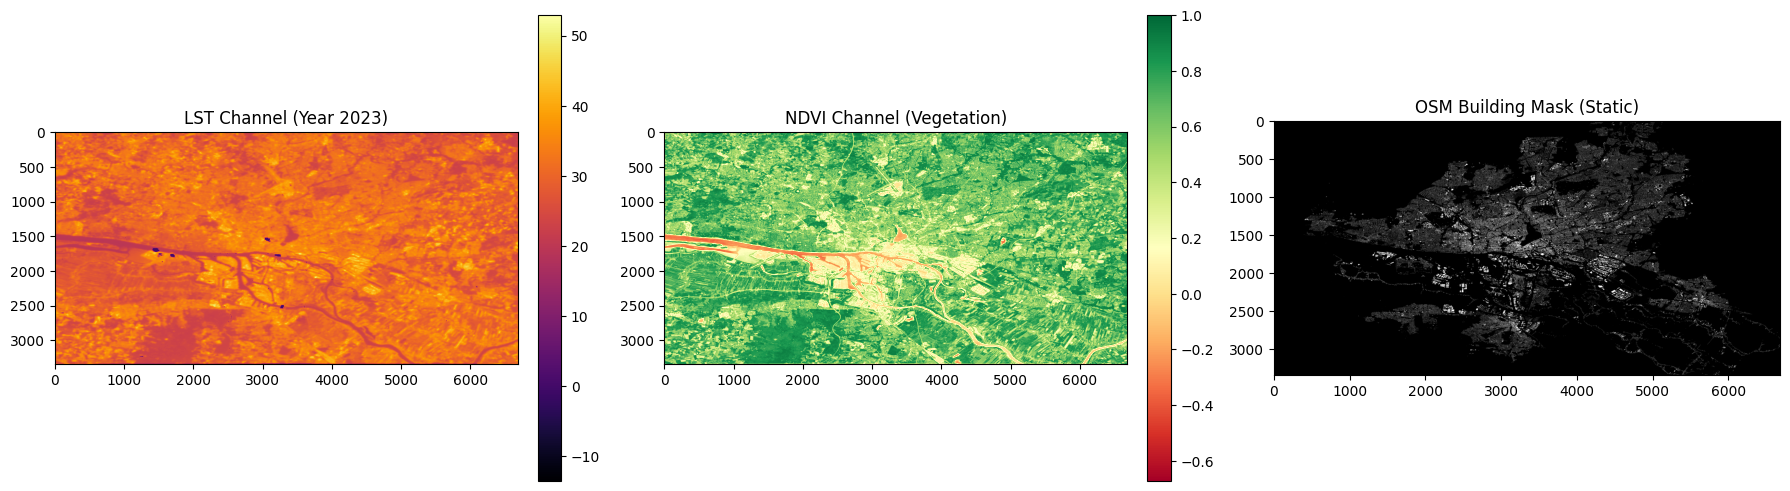

Verification: Check if the hot areas (LST) overlap with buildings or roads.


In [11]:
import matplotlib.pyplot as plt

# 1. Select a year to visualize (e.g., the most recent one)
test_year = 2023
test_tensor = final_tensors[test_year]

# Channels: 0:LST, 1:NDVI, 2:NDBI, 3:Building, 4:Road, 5:Water
# We will visualize LST, NDVI, and Building Mask to check alignment

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot LST
im0 = axes[0].imshow(test_tensor[0], cmap='inferno')
axes[0].set_title(f"LST Channel (Year {test_year})")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Plot NDVI
im1 = axes[1].imshow(test_tensor[1], cmap='RdYlGn')
axes[1].set_title("NDVI Channel (Vegetation)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Plot Building Mask
im2 = axes[2].imshow(test_tensor[3], cmap='gray')
axes[2].set_title("OSM Building Mask (Static)")

plt.tight_layout()
plt.show()

print("Verification: Check if the hot areas (LST) overlap with buildings or roads.")

### U-Net Modeling 

We have successfully prepared the data. Now, we enter the **Deep Learning Phase**.
We will train a **U-Net** model to understand the complex relationship between urban features (Buildings, Roads, Vegetation) and surface temperature.

#### 1. Input Data Structure
The model will ingest the **6-Channel Tensors** we just saved in `data/processed/`.
* **Dynamic Channels:** LST (Target/Input), NDVI, NDBI.
* **Static Channels:** OSM Buildings, Roads, Water.

#### 2. Model Architecture
* **Type:** Standard U-Net (Encoder-Decoder with Skip Connections).
* **Goal:** **Semantic Segmentation** of UHI Hotspots. The model will learn to classify pixels as "Heat Island" or "Neutral" based on their spectral and structural properties.

#### 3. Execution Plan 
We will tackle this complex phase in 5 manageable sprints:

* **Day 1:** Define U-Net Architecture (PyTorch implementation).
* **Day 2:** Build Custom DataLoader (Handling `.npy` files & Augmentation).
* **Day 3:** Setup Training Loop & Loss Functions (Dice Loss / BCE).
* **Day 4:** First Training Run & Hyperparameter Tuning.
* **Day 5:** Evaluation & Visualizing Predictions vs. Ground Truth.